In [1]:
# To setup everything (on the bash terminal to execute jupyter nb)
# !./install.sh
# !. ./env.sh
# !which python
# !jupyter notebook --ip="0.0.0.0" 

In [2]:
from ipywebrtc import AudioRecorder, CameraStream
import torch, torchaudio, os, tempfile, subprocess
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from IPython.display import Audio, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

In [3]:
recordid="001"

text_gt = subprocess.check_output(f"cat pkwrap/egs/librispeech/v1/data/vctk_test_trials_f_common/text | head -n{recordid} | tail -n1 | cut -d\  -f2-", shell=True).decode("UTF-8").strip()
print(text_gt)
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
display(recorder)

PLEASE CALL STELLA


AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [4]:
# Recorded Audio from previous cell

if len(recorder.audio.value) != 0:
    tmpf = tempfile.NamedTemporaryFile(suffix='.webm')
    tmpfwav = tempfile.NamedTemporaryFile(suffix='.wav').name
    tmpf.write(recorder.audio.value)
    webm = tmpf.name
    !ffmpeg -i $webm -ac 1 -f wav $tmpfwav -y -hide_banner -loglevel panic 
    tmpf.close()
    waveform, sr = torchaudio.load(tmpfwav)

else:
    # waveform, sr = torchaudio.load(f"pkwrap/egs/librispeech/v1/data/vctk_test/wav/p226/p226_{recordid}_mic2.wav")

#     waveform, sr = torchaudio.load(f"speech-resynthesis/data/LJSpeech-1.1/wavs_16khz/LJ001-0011.wav")
#     text_gt = "IT IS OF THE FIRST IMPORTANCE THAT THE LETTER USED SHOULD BE FINE IN FORM"

    # waveform, sr = torchaudio.load(f"pkwrap/egs/librispeech/v1/corpora/LibriSpeech/test-other/2414/128292/2414-128292-0015.flac")
    # text_gt = "WHEN THE DEVIL CASTETH HIS SKIN DOTH NOT HIS NAME ALSO FALL AWAY IT IS ALSO SKIN"

    waveform, sr = torchaudio.load(f"pkwrap/egs/librispeech/v1/corpora/LibriSpeech/test-other/2414/128292/2414-128292-0018.flac")
    text_gt = "THEN ONLY DID I HIT THE TRUTH"

    # waveform, sr = torchaudio.load(f"pkwrap/egs/librispeech/v1/corpora/LibriSpeech/test-other/1688/142285/1688-142285-0015.flac")
    # text_gt = "HOW TAINTED ASKED HER FATHER"

    # waveform, sr = torchaudio.load(f"pkwrap/egs/librispeech/v1/corpora/LibriSpeech/test-other/6938/70848/6938-70848-0012.flac")
    # text_gt = "WHEREUPON THE OLD EXECUTIVE COMMITTEE LEFT THE HALL"

    # waveform, sr = torchaudio.load(f"speech-resynthesis/data/LJSpeech-1.1/wavs_16khz/LJ001-0011.wav")
    # text_gt = "IT IS OF THE FIRST IMPORTANCE THAT THE LETTER USED SHOULD BE FINE IN FORM"

    # waveform, sr = torchaudio.load(f"pkwrap/egs/librispeech/v1/corpora/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac")
    # text_gt = "MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL"


waveform = torchaudio.transforms.Resample(orig_freq=sr,
                                                   new_freq=16000)(waveform)
waveform = waveform.to(device)
Audio(data=waveform.cpu(), rate=16000)

In [5]:
import demo
_pk_model, module  = demo.init_pkwrap_model(
    model="local/chain/e2e/tuning/tdnnf_wav2vec_vq.py",
    exp_path="exp/chain/e2e_tdnnf_wav2vec_vq_256/",
    pkwrap_vq_dim="256",
    get_model_module=True,
)

_out, net = _pk_model(waveform.to(device).clone())
_text, align = demo.kaldi_asr_decode(_out, get_align=True)
print(_text)

Loading 'exp/chain/e2e_tdnnf_wav2vec_vq_256/final.pt'
THEN ONLY DID I HATE THY TRUTH


In [6]:
def forward_from_bn(bn, module):
    with torch.no_grad():
        x = module.prefinal_chain_vq.tdnn.linearA(bn)
        x = x.permute(0, 2, 1)
        x = module.prefinal_chain_vq.bn(x)
        x = x.permute(0, 2, 1)
        x = torch.nn.functional.relu(x)
        for i in range(len(module.tdnnfs_decode)):
            x = module.tdnnfs_decode[i](x)
        __out = module.chain_output(x)
    __text, __align = demo.kaldi_asr_decode(__out, get_align=True)
    return __out, __text, __align

assert module.prefinal_chain_vq.tdnn.use_bypass == False # If vq bottleneck

quant_id = torch.flatten(net.encoding_indices).tolist()
# print(len(quant_id), quant_id)
# quant_id = [0, 0, 0, 0, 0, 2, 2, 2, 2, 29, 19, 19, 19, 8, 18, 18, 18, 18, 18]
# quant_id = [255, 255, 336, 336, 34, 457, 49, 110, 133, 148, 197, 197, 197, 197,
#            255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 306, 306, 306, 309, 
#             234, 353, 294, 478, 511, 304, 63, 207, 40, 131, 185]
print(quant_id)
with torch.no_grad():
    bn = module.quant.embedding(torch.tensor(quant_id, device=device)).unsqueeze(0)

# print(bn)
# print(net.bottleneck_out)
# print((bn - net.bottleneck_out).sum())
# assert torch.allclose(bn, net.bottleneck_out, atol=1e-5), (bn - net.bottleneck_out).sum() # Close to absolute tolerance

__out, __text, _ = forward_from_bn(bn, module)
print(__text)
# assert _text == __text

[213, 213, 132, 21, 146, 146, 146, 146, 213, 213, 47, 86, 16, 74, 253, 114, 4, 24, 205, 166, 91, 54, 54, 203, 9, 9, 78, 145, 214, 159, 159, 184, 93, 47, 47, 47, 47, 47, 47, 47, 47, 213, 213, 100, 249, 145, 214, 47, 93, 196, 69, 198, 198, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230]
THEN ONLY DID I HATE THY TRUTH


Loading 'checkpoints/lj_vq_tdnnf_asr_wav2vec_vq_256/g_00055000'
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.00

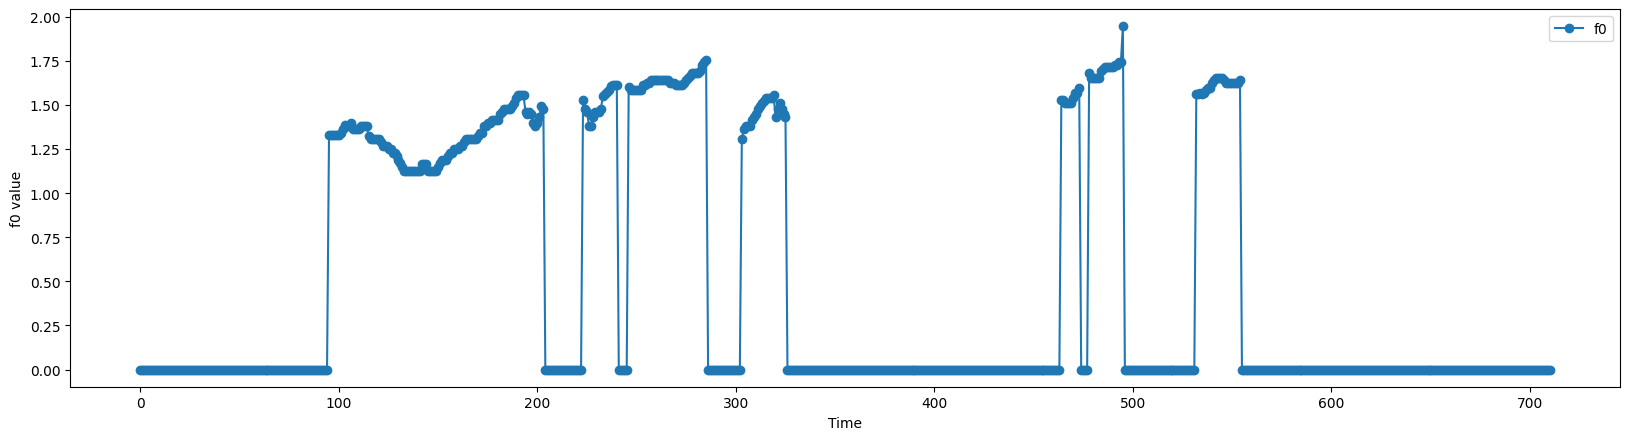

In [7]:
wav2vec_synthesis_model, synthesis_sr, _ = demo.init_speech_synthesis_model(
    "checkpoints/lj_vq_tdnnf_asr_wav2vec_vq_256/config.json",
    "checkpoints/lj_vq_tdnnf_asr_wav2vec_vq_256/g_00055000",
    root_dir="speech-resynthesis/",
)

f0 = demo.get_f0(
    waveform.cpu(), f0_stats_file="speech-resynthesis/datasets/LJSpeech/f0_stats.pth"
)

print(f0)

# f0 = torch.tensor([[[0.0000,  0.0000,  0.0000,  0.0000,
#            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#            0.0000,  0.0000,  0.0000,  0.0000, -1.7960, -1.7960, -1.7960,
#           -1.7960, -1.7960, -1.7960, -1.7960, -1.7849, -1.7738, -1.7628,
#           -1.7628, -1.7628, -1.7738, -1.7849, -1.7960, -1.7960, -1.8071,
#           -1.8182, -1.8292, -1.8292, -1.8292, -1.8292, -1.8343, -1.8451,
#           -1.8664, -1.8957, -1.8957, -1.8957, -1.9074, -1.9173, -1.9173,
#           -1.9173, -1.9272, -1.9272, -1.9272, -1.9272, -1.9465, -1.9559,
#           -1.9559,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#           -1.5103, -1.5103, -1.4303,
#           -1.4285, -1.4223, -1.4112, -1.3953, -1.3794, -1.3683, -1.3639,
#           -1.3639, -1.3639, -1.3639, -1.3639, -1.3639, -1.3639, -1.3749,
#           -1.3941, -1.4136, -1.4136, -1.9746, -1.9928, -1.9928, -2.2853,
#           -1.9928, -1.3439, -1.3617, -1.8558, -1.8558, -1.3793, -2.1016,
#            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#            0.0000, -1.5103, -1.6305, -1.6298, -1.6409, -1.6630, -1.7074,
#           -1.7517, -1.7960, -1.8182, -1.8403, -1.8625, -1.8957, -1.9290,
#           -1.9622, -1.9954, -2.0176, -2.0287, -2.1016, -2.1173, -2.1962,
#           -2.2229, -2.2229, -2.2163, -2.2163, -2.2163, -2.2163, -2.2163,
#           -2.2163, -2.2163, -2.2163, -2.2163, -2.1541, -2.3634, -2.3941,
#            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,]]])


%matplotlib inline
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(20,5))
fig1.set_dpi(100.0)

ax1 = fig1.add_subplot(111)
line1 = ax1.plot(f0[0][0].cpu().abs(), 'o-', label='f0')

plt.xlabel("Time")
plt.ylabel("f0 value")
plt.legend()

audio = wav2vec_synthesis_model(bn.permute(0, 2, 1).contiguous(), f0.to(device))[0]
print(audio.shape)
display(Audio(data=audio[:waveform.shape[1]], rate=synthesis_sr))